#Test script for aperture-extraction from Hyperion & photutils

###Import modules

In [1]:
%matplotlib inline
import numpy as np
from hyperion.model import ModelOutput
import matplotlib.pyplot as plt
from photutils import aperture_photometry as ap
from photutils import CircularAperture
import astropy.constants as const
from astropy.io import ascii
from scipy.interpolate import interp1d

# constant setup
pc = const.pc.cgs.value
c  = const.c.cgs.value
AU = const.au.cgs.value

# The wavelengths that aperture extraction performed
wl_aper = [3.6, 4.5, 5.8, 8.0, 8.5, 9, 9.7, 10, 10.5, 11, 16, 20, 24, 35, 70, 100, 160, 250, 350, 500, 850]

In [3]:
# path to model output
# filename = 'model47.rtout'
# text_aper = 'model47_sed_w_aperture.txt'
filename = '/Users/yaolun/bhr71/hyperion/cycle6/model47.rtout'
text_aper = '/Users/yaolun/bhr71/hyperion/cycle6/model47_sed_w_aperture.txt'

##Extract spectro-photometry from infinite-aperture Hyperion output

For wavelengths given in In[1], calculate the total flux within the corresponding aperture.

In [6]:
# read in the model output and set up the pixel scale
m = ModelOutput(filename)
im = m.get_image(group=len(wl_aper)+1, inclination=0, distance=178.*pc, units='MJy/sr')
w = np.degrees((2e4*AU)/im.distance)*3600
print w
pix_num = len(im.val[:,0,0])
pix2arcsec = 2*w/pix_num
# convert the flux units into Jy/pix
im.val = im.val*1e6/4.25e10*pix2arcsec**2

112.359550563


In [11]:
print pix2arcsec
print pix_num

0.749063670418
300


In [4]:
# read in the model output and set up the pixel scale
m = ModelOutput(filename)
im = m.get_image(group=len(wl_aper)+1, inclination=0, distance=178.*pc, units='Jy')
# w = np.degrees((1.5*pc)/im.distance)*60
# pix_num = len(im.val[:,0,0])
# pix2arcsec = 2*w/pix_num
# # convert the flux units into Jy/pix2
# im.val = im.val*1e6/4.25e10*pix2arcsec**2

In [7]:
# set up the aperture for given wavelength
aper = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    if wl_aper[i] <= 20:
        aper[i] = 7.2 * wl_aper[i]/10.
    elif (wl_aper[i] > 20) & (wl_aper[i] <=50):
        aper[i] = 7.2 * 2
    else:
        aper[i] = 24.5

# set up resolution averaging window
# use a finite spectral resolution
res = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
        res[i] = 600.
    elif wl_aper[i] < 5:
        res[i] = 10.
    else:
        res[i] = 1000.

# iternate through the wavelengths that aperture extraction performed.
# And store the extraced fluxes in variable "phot"
# The unit is changed to vSv [erg/s/cm2]
phot = np.empty_like(wl_aper)
for i in range(len(wl_aper)):
    apertures = CircularAperture((pix_num/2.-1,pix_num/2.-1), r=aper[i]/pix2arcsec)
    wav = wl_aper[i]
    iwav = np.argmin(np.abs(wav - im.wav))
    if len(np.where((im.wav < wl_aper[i]*(1+1./res[i])) & (im.wav > wl_aper[i]*(1-1./res[i])))[0]) != 0:
        im_avg = np.mean(im.val[:,:,(im.wav < wl_aper[i]*(1+1./res[i])) & (im.wav > wl_aper[i]*(1-1./res[i]))],axis=2)
    else:
        im_avg = im.val[:,:,iwav]
    phot_table = ap(im_avg, apertures)
    phot[i] = phot_table['aperture_sum'].data[0]*c/wav*1e4*1e-23 # convert to unit of erg/s/cm2 (vSv)

##Read in the model output with aperture specified

In [8]:
# get flux at different apertures from different peeled-sed
flux_aper = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    sed_dum = m.get_sed(group=i+1, inclination=0, aperture=-1, distance=178. * pc)
    # apply the spectral resolution
    if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
        res = 600.
    elif wl_aper[i] < 5:
        res = 10.
    else:
        res = 1000.
    ind = np.where((sed_dum.wav < wl_aper[i]*(1+1./res)) & (sed_dum.wav > wl_aper[i]*(1-1./res)))
    if len(ind[0]) != 0:
        flux_aper[i] = np.mean(sed_dum.val[ind])
    else:
        f = interp1d(sed_dum.wav, sed_dum.val)
        flux_aper[i] = f(wl_aper[i])
flux_aper = flux_aper

In [48]:
# read in the sed_w_aperture.txt
# not really need to read this in
# sed_w_aper = ascii.read(text_aper)

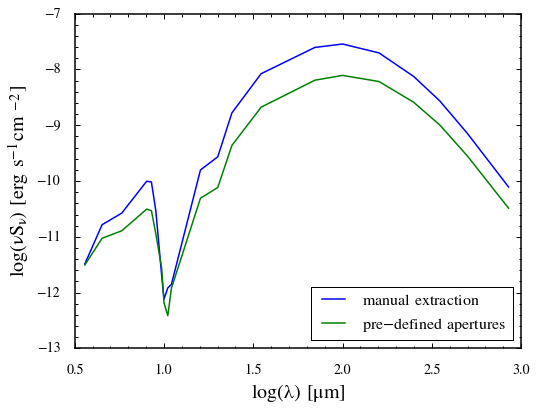

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

inf, = ax.plot(np.log10(wl_aper), np.log10(phot), 'b-', linewidth=1.5, label=r'$\rm{manual\,extraction}$')
# plt.plot(np.log10(sed_w_aper['wave']), np.log10(sed_w_aper['vSv']))
sed, = ax.plot(np.log10(wl_aper), np.log10(flux_aper), 'g-', linewidth=1.5, label=r'$\rm{pre-defined\,apertures}$')
ax.legend(loc='best', fontsize=16)
ax.set_xlabel(r'$\rm{log(\lambda)\,[\mu m]}$', fontsize=20)
ax.set_ylabel(r'$\rm{log(\nu S_{\nu})\,[erg\,s^{-1} cm\,^{-2}]}$', fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on() 
ax.tick_params('both',labelsize=14,width=1,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=14,width=1,which='minor',pad=15,length=2.5)

##Compare the SED with infinite aperture (Hyperion) vs sum of the image cube

In [46]:
# model output is already read in
# sum over the field of view
im_avg_1d = np.sum(im.val, axis=(0,1)) * 1e6/4.25451703e10*pix2arcsec**2*1e-23 * c/im.wav*1e4

# read in the SED with the infinite aperture
sed_inf = m.get_sed(group=0, inclination=0, aperture=-1, distance=178.0*pc)

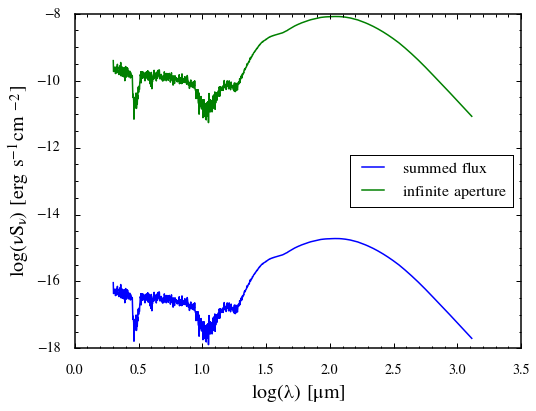

In [47]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(im.wav), np.log10(im_avg_1d), 'b-', linewidth=1.5, label=r'$\rm{summed\,flux}$')
ax.plot(np.log10(sed_inf.wav), np.log10(sed_inf.val),'g-', linewidth=1.5, label=r'$\rm{infinite\,aperture}$')

ax.legend(loc='best', fontsize=16)
ax.set_xlabel(r'$\rm{log(\lambda)\,[\mu m]}$', fontsize=20)
ax.set_ylabel(r'$\rm{log(\nu S_{\nu})\,[erg\,s^{-1} cm\,^{-2}]}$', fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on() 
ax.tick_params('both',labelsize=14,width=1,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=14,width=1,which='minor',pad=15,length=2.5)